In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML
# import line_profiler as lp 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import sys
sys.path.append('../src')
# from model import *
from model2D import *
from datagen import *
from analysis import *
from datagen2D import *

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU: ", device)
else:
    device = torch.device("cpu")
    print("Running on CPU")

torch.set_default_device(device)
# torch.cuda.synchronize()
torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision("high")

/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on GPU:  cuda:0
Running on GPU:  cuda:0


/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/umap/d

Running on GPU:  cuda:0


## Dataset Testing

In [2]:
# lp profile of smooth_wandering_2D_complex_bound
# %load_ext line_profiler
# %lprun -f smooth_wandering_2D_complex_bound smooth_wandering_2D_complex_bound(64,200,bound=0.5,v_sigma=0.02,d_sigma=0.1)

## Model

In [3]:
# input_data = np.load("../datasets/gradual_2D_hdv_randomstart_5000_25_64.npy",allow_pickle=True)
input_data = np.load("../datasets/gradual_2D_hdv_randomstart_500_5_64.npy",allow_pickle=True)
# input_data = np.load("../datasets/constant_2D_hdv_randomstart_200_200_64.npy",allow_pickle=True)
# input_data = hd_direction_input_convert(input_data)

alloc!


Loss:   0%|          | 0/500 [00:00<?, ?it/s]

Loss: 1.16267: 100%|██████████| 500/500 [03:12<00:00,  2.59it/s]         

Losses array was not a multiple of average. Truncated to 480


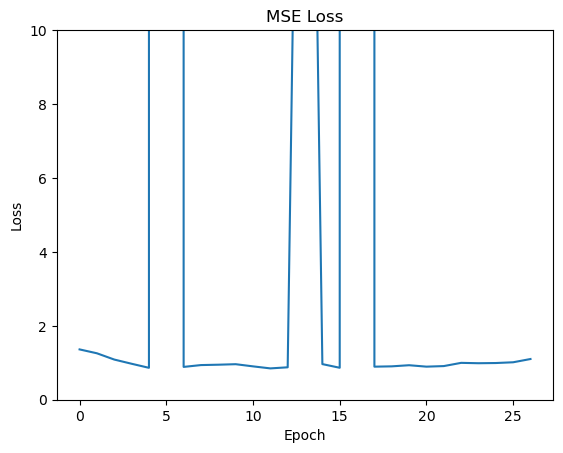

In [5]:
hidden_size = 20
input_size = 2
# nav_size = 1



# model1 = RNN_circular_LowEtAl_bridged(input_size,hidden_size,lr=0.0001,irnn=True,outputnn=False,Wx_normalize=False,activation=True,bias=False,nav_space=1,batch_size=64).to(device)
# model1 = RNN_circular_2D_xy_Low_randomstart(input_size,hidden_size,lr=0.0002,act_decay=1.0,weight_decay=0.01,noise=0.01).to(device)
# model1 = RNN_circular_1D_to_2D_arccos(input_size,hidden_size,lr=0.0002,act_decay=1.0,weight_decay=0.01,noise=0.01).to(device)
# model1 = CwRNN_low(input_size,hidden_size,n_modules=3).to(device)
# model1 = RNN_circular_2D_randomstart_trivial_sorcher(input_size,hidden_size,lr=0.0002,act_decay=1.0,weight_decay=0.01,noise=0.01,bias=False).to(device)
model1 = LTC_solver_Low(input_size,hidden_size,act_decay=1.0,weight_decay=0.01,lr=0.005).to(device)
# model1 = RNN_circular_2D_xy_relative_randomstart(input_size,hidden_size,lr=0.0002,act_decay=0.01,weight_decay=0.00).to(device)
model1 = torch.compile(model1)



train = True

if train:
    # _ = model1.train_gradual(epochs=1500)
    _ = model1.train_gradual_manual(input_data)
    # _ = model1.train_gradual_loader(data_loader)
    # model1.base_training_tsteps = 40
    # _ = model1.train(epochs=10000)
    model1.plot_losses(average=30)
else:
    # model1.load_state_dict(torch.load("../trained models/LowEtAl_bridged_10000gradual+2000base.pt"))
    # model1.load_state_dict(torch.load("../trained models/LowEtAl_bridged_10000gradual.pt",map_location=torch.device('cpu')))
    torch.cuda.empty_cache()
    model1.load_state_dict(torch.load("../trained models/LTC_N16_1000gradual_hdv_Sophia_200tsteps_actdecay_weightdecay_0.005lr.pt",map_location=torch.device('cpu')))
    
# torch.save(model1.state_dict(), "../trained models/LowEtAl_bridged_reduced_Gradual_lossiequaloroverj_maskonangle_lossscale_4000gradual.pt")

Loss: 0.90968: 100%|██████████| 500/500 [03:12<00:00,  2.60it/s]

Losses array was not a multiple of average. Truncated to 990


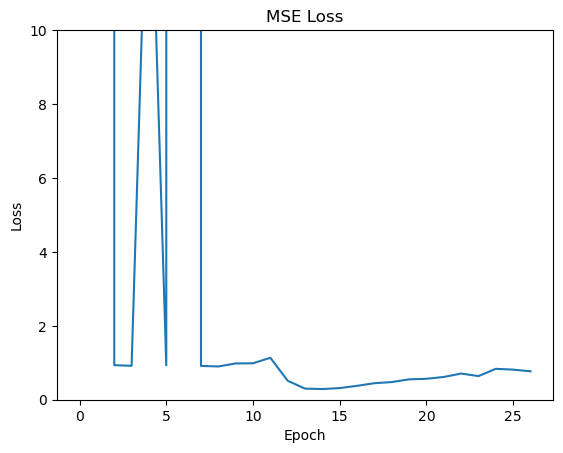

In [6]:
# input_data = np.load("../datasets/constant_2D_2000_200_64.npy",allow_pickle=True)
# model1.optimizer = SophiaG(model1.parameters(), lr=0.001, weight_decay=model1.weight_decay)
model1.optimizer = torch.optim.Adam(model1.parameters(), lr=0.005, weight_decay=model1.weight_decay)
_ = model1.train_gradual_manual(input_data)
model1.plot_losses(average=30)

In [9]:
# model1.base_training_tsteps = 200
# _ = model1.train(epochs=1)
# model1.plot_losses(average=30)

In [39]:
# torch.save(model1.state_dict(), "../trained models/LTC_N20_500+500gradual_hdv_Sophia+Adam_100tsteps_0.005lr.pt")
# torch.save(model1.state_dict(), "../trained models/LTC_N20_500+500gradual_hdv_Sophia+Adam_100tsteps_actdecay_weightdecay_0.005lr.pt")

## Analysis

### Norm of activity per timestep

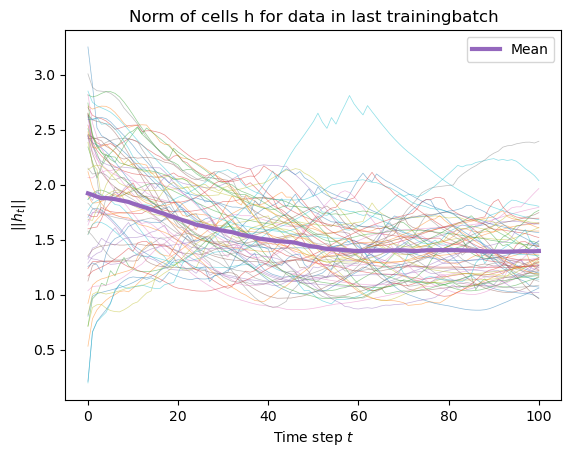

Mean norm:  1.5289748


In [7]:
htss = model1.hts.norm(dim=2)
htss = htss.cpu().detach().numpy()
plot_norm(htss,avg_only=False)

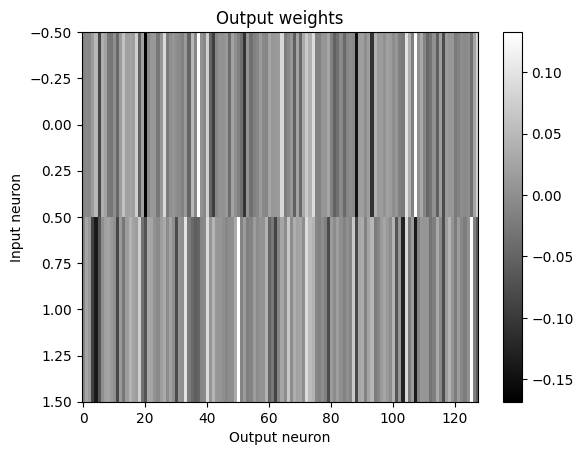

In [5]:
outweights = model1.start_encoder.weight
plt.imshow(outweights.T.cpu().detach().numpy(), cmap='gray',aspect="auto",interpolation="nearest")
plt.colorbar()
# Enlarge the x axis to make the plot clearer
# plt.xlim(0, 100)
plt.xlabel('Output neuron')
plt.ylabel('Input neuron')
plt.title('Output weights')
plt.show()

# Choose elements that are greater than 0.1
# (outweights.T > 0.2).cpu().detach().numpy().argmax(axis=0)

In [6]:
model1.start_encoder.bias

### Tuning curves

#### 1D

In [11]:
# activity, bin_edges = tuning_curve(model1,bins=2000)
# plot_tuning_curve(activity,bin_edges,91,spherical=False,linear=False,scale_to_one=True, plot_head_frac=1/10)

#### 2D Tuning curves

In [8]:
torch._dynamo.config.suppress_errors = True
t_test = 200
test_batch_size = 5000
# data,labels = smooth_wandering_2D_squarefix_randomstart_hdv(test_batch_size,t_test,bound=0.5,v_sigma=0.01,d_sigma=0.08,v_bound_reduction=0.15,stability=0.00)
# data,labels = lowetal_2D(test_batch_size,t_test)
# data,labels = smooth_wandering_2D_circular(test_batch_size,t_test,bound=0.5,v_sigma=0.01,d_sigma=0.1)
data,labels = smooth_wandering_2D_circular_randomstart_hdv(test_batch_size,t_test,bound=0.5,v_sigma=0.01,d_sigma=0.08)

In [14]:
# torch.set_float32_matmul_precision('high')
torch._dynamo.config.verbose=True
activity, bin_edges_x, bin_edges_y = tuning_curve_2D_fullmodel(model1,bins=100, in_activity=(data, labels),start=data[:,0,:])

100%|██████████| 40/40 [00:03<00:00, 10.68it/s]


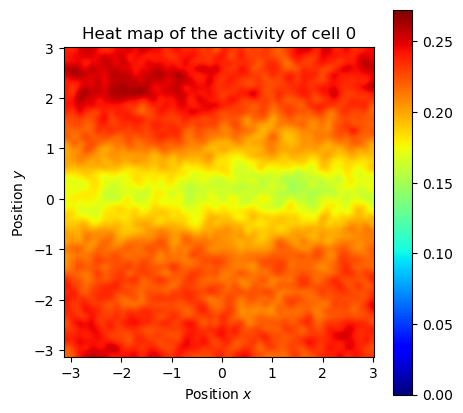

100%|██████████| 40/40 [00:00<00:00, 1631.06it/s]


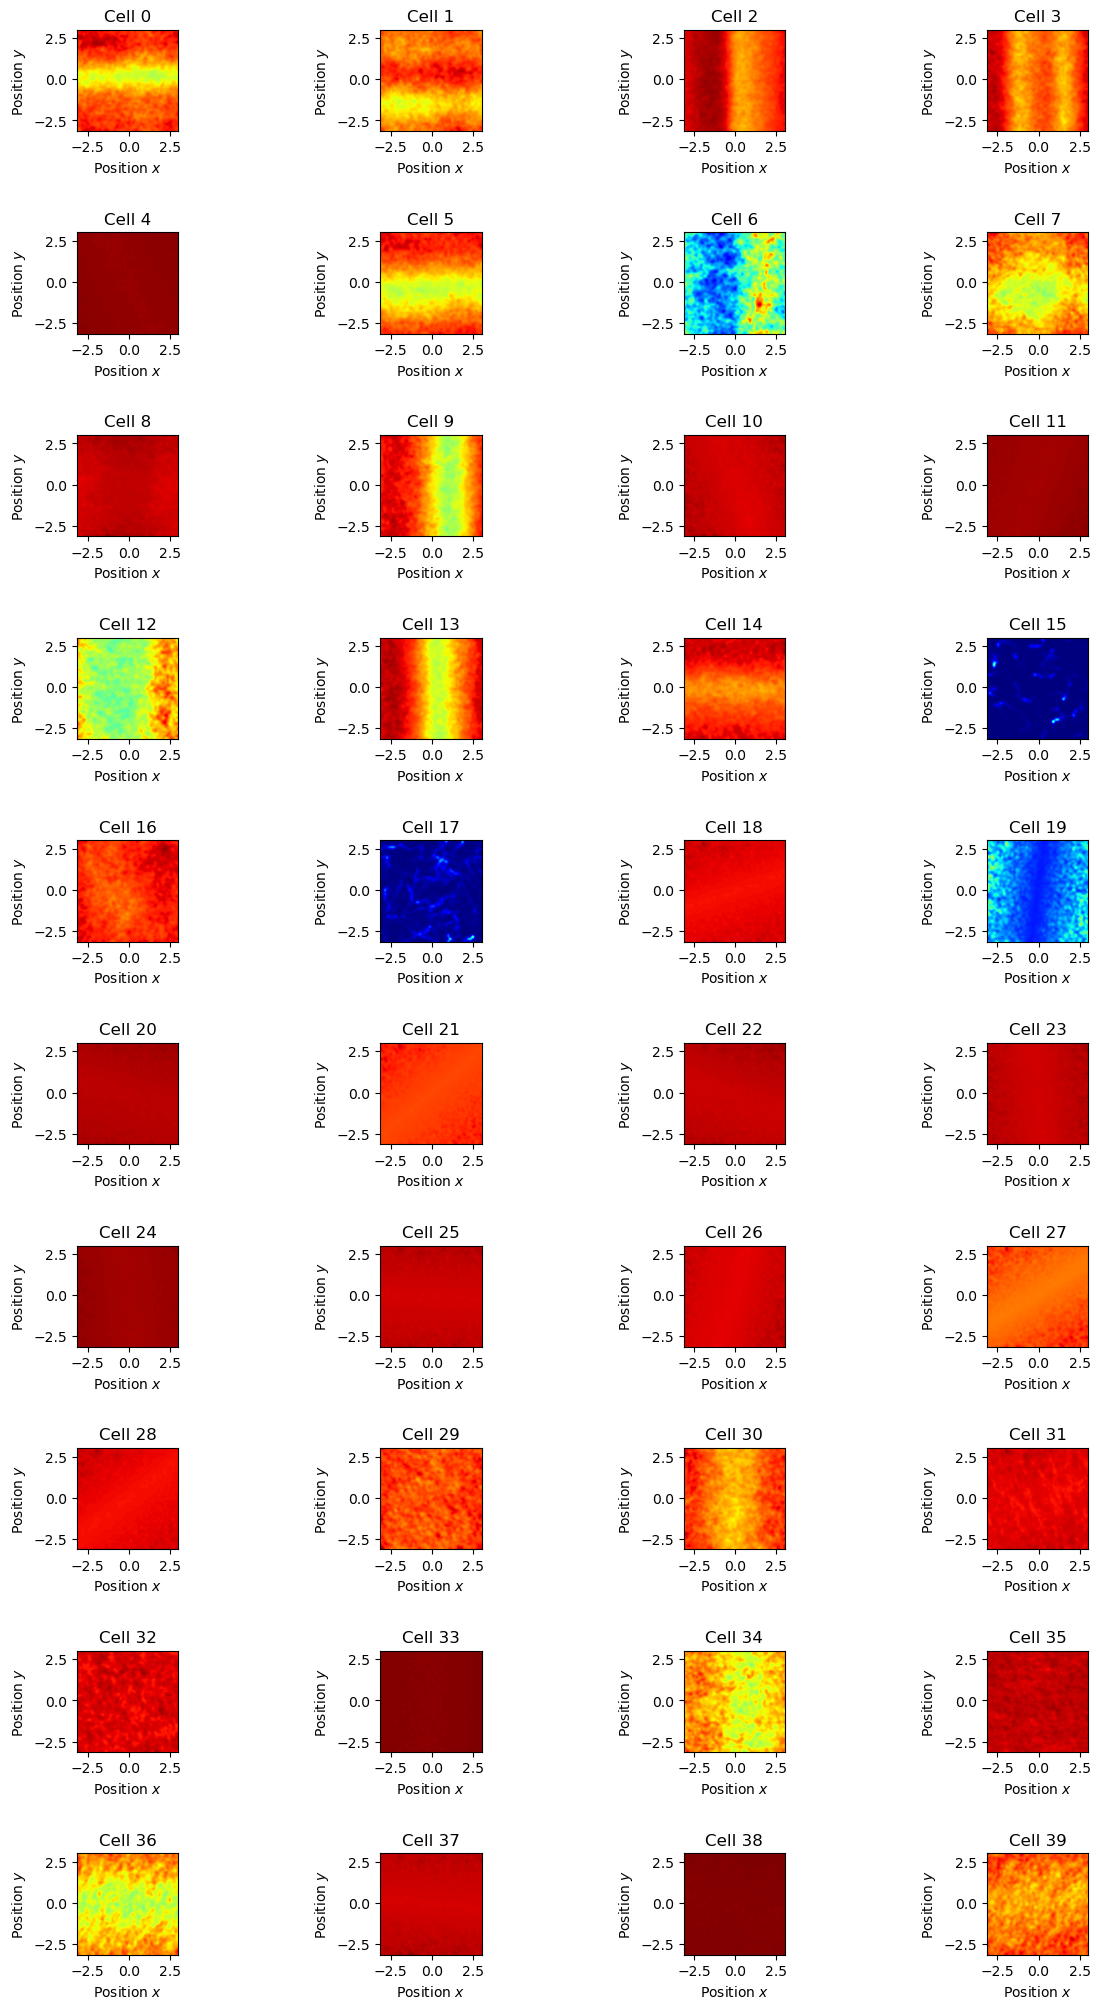

In [10]:
plot_2D_tuning_curve_2(activity,bin_edges_x, bin_edges_y,k_test=0,plot_head_frac=1,scale_to_one=False,more_plots=True)

In [36]:
activity.shape

(40, 50, 50)

### Low dimensional representations

#### 1D

In [15]:
activity_flat = activity.reshape(activity.shape[0],-1)
embedding, reducer = lowD_reduce(activity_flat,if_pca=False,n_components=3,plot=True,n_neighbors=1000)

(10000, 3)


#### 2D

In [ ]:
# xembedding, xreducer = lowD_reduce(xactivity,if_pca=True,n_components=2,plot=True)
# yembedding, yreducer = lowD_reduce(yactivity,if_pca=True,n_components=2,plot=True)

### Accuracy testing

#### 1D

In [11]:
# angs, dy, err, y_hat, y = test_angle_inference(model1,reducer)


In [10]:
# plot_accuracy(angs,dy,y_hat,y)

In [9]:
# plot_path_accuracy(angs,y,example_path=1)

#### 2D accuracy testing

In [10]:
data,labels = smooth_wandering_2D_squarefix(300,200,bound=0.5,v_sigma=0.01,d_sigma=0.1,v_bound_reduction=0.15,stability=0.01)
# data,labels = smooth_wandering_2D_complex_bound(200,200,bound=0.5,v_sigma=0.01,d_sigma=0.1)

xdata = data[:,:,0]
ydata = data[:,:,1]
xlabels = labels[:,:,0]
ylabels = labels[:,:,1]

# call old y for theta (theoretical angles)
xangs, xdtheta, xerr, xhidden_state, xtheta = test_angle_inference(model1,reducer,t_test=200,in_activity=(xdata,xlabels),start=0)
yangs, ydtheta, yerr, yhidden_state, ytheta = test_angle_inference(model1,reducer,t_test=200,in_activity=(ydata,ylabels),start=0)

NameError: name 'reducer' is not defined

In [ ]:
xlabels[0,0]

tensor(-0.0081)

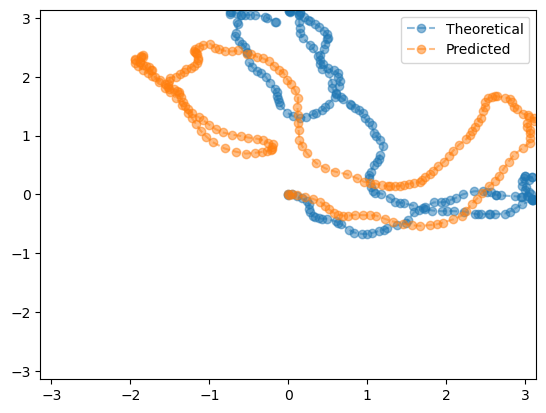

In [ ]:

n = 13
pos = np.zeros((xangs.shape[0],xangs.shape[1]+1,2))
pos[:,:,0] = xtheta
pos[:,:,1] = ytheta
plt.plot(xtheta[n,:],ytheta[n,:],'--o', alpha=0.5, label='Theoretical')

xpath = np.zeros((xangs.shape[0],xangs.shape[1]+1))
ypath = np.zeros((xangs.shape[0],xangs.shape[1]+1))
# xpath[:,0] = 0
# ypath[:,0] = 0
for i in range(1,xangs.shape[1]+1):
    xpath[:,i] = xpath[:,i-1] + xangs[:,i-1]
    ypath[:,i] = ypath[:,i-1] + yangs[:,i-1]

pos_hat = np.zeros((xangs.shape[0],xangs.shape[1]+1,2))
pos_hat[:,:,0] = xpath
pos_hat[:,:,1] = ypath

plt.plot(xpath[n,:],ypath[n,:],'--o', alpha=0.5, label='Predicted')
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi,np.pi)
# plt.axis('equal')
plt.legend()
plt.show()

In [8]:
# plt.plot(xtheta[n,:],label="Theoretical x")
# plt.plot(xpath[n,:],label="Predicted x")
# plt.legend()
# plt.show()
# plt.plot(ytheta[n,:],label="Theoretical y")
# plt.plot(ypath[n,:],label="Predicted y")
# plt.legend()
# plt.show()

In [ ]:
# MSE of predicted vs theoretical
print(np.mean((pos-pos_hat)**2))

0.6606481727624923


#### 2/3D accuracy testing

In [ ]:
n_test = 300
t_test = 200
data,labels = smooth_wandering_2D_squarefix(n_test,t_test,bound=0.5,v_sigma=0.01,d_sigma=0.1,v_bound_reduction=0.15,stability=0.01)
# data,labels = smooth_wandering_2D_complex_bound(200,200,bound=0.5,v_sigma=0.01,d_sigma=0.1)

print(labels[0,0], labels[0,1])

data, labels, basises = convert_2D_23D(data,labels)
xdata = data[:,:,0]
ydata = data[:,:,1]
zdata = data[:,:,2]
xlabels = labels[:,:,0]
ylabels = labels[:,:,1]
zlabels = labels[:,:,2]

# call old y for theta (theoretical angles)
xangs, xdtheta, xerr, xhidden_state, xtheta = test_angle_inference(model1,reducer,t_test=200,in_activity=(xdata,xlabels),start=0)
yangs, ydtheta, yerr, yhidden_state, ytheta = test_angle_inference(model1,reducer,t_test=200,in_activity=(ydata,ylabels),start=0)
zangs, zdtheta, zerr, zhidden_state, ztheta = test_angle_inference(model1,reducer,t_test=200,in_activity=(zdata,zlabels),start=0)

415
tensor([0.0123, 0.0034]) tensor([0.1088, 0.0592])
Mean error:  0.024822749514228425
Mean error:  0.02480916146825378
Mean error:  0.0250689123834516


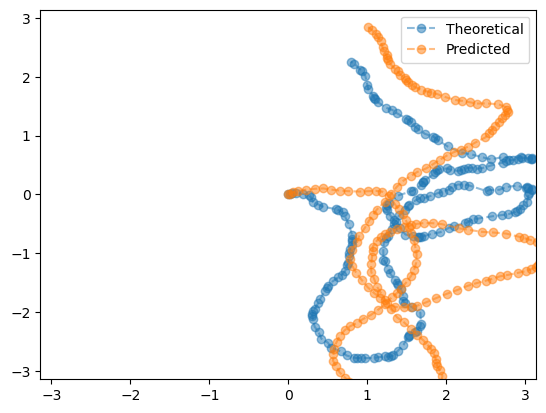

In [ ]:
basises = np.array(basises)

pos = np.zeros((n_test,t_test+1,2))
pos[:,:,0] = xtheta*basises[0,0] + ytheta*basises[1,0] + ztheta*basises[2,0]
pos[:,:,1] = xtheta*basises[0,1] + ytheta*basises[1,1] + ztheta*basises[2,1]

n = 299
plt.plot(pos[n,:,0],pos[n,:,1],'--o', alpha=0.5, label='Theoretical')
xpath = np.zeros((xangs.shape[0],xangs.shape[1]+1))
ypath = np.zeros((xangs.shape[0],xangs.shape[1]+1))
zpath = np.zeros((xangs.shape[0],xangs.shape[1]+1))
# xpath[:,0] = 0
# ypath[:,0] = 0
for i in range(1,xangs.shape[1]+1):
    xpath[:,i] = xpath[:,i-1] + xangs[:,i-1]
    ypath[:,i] = ypath[:,i-1] + yangs[:,i-1]
    zpath[:,i] = zpath[:,i-1] + zangs[:,i-1]
pos_hat = np.zeros((n_test,t_test+1,2))
pos_hat[:,:,0] = xpath*basises[0,0] + ypath*basises[1,0] + zpath*basises[2,0]
pos_hat[:,:,1] = xpath*basises[0,1] + ypath*basises[1,1] + zpath*basises[2,1]
plt.plot(pos_hat[n,:,0],pos_hat[n,:,1],'--o', alpha=0.5, label='Predicted')
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi,np.pi)
plt.legend()
plt.show()

In [7]:
# plt.plot(xtheta[n,:],label="Theoretical x")
# plt.plot(xpath[n,:],label="Predicted x")
# plt.legend()
# plt.show()
# plt.plot(ytheta[n,:],label="Theoretical y")
# plt.plot(ypath[n,:],label="Predicted y")
# plt.legend()
# plt.show()
# plt.plot(ztheta[n,:],label="Theoretical z")
# plt.plot(zpath[n,:],label="Predicted z")
# plt.legend()
# plt.show()

In [ ]:
# Mean squared error of pos and pos_hat
print(np.mean((pos-pos_hat)**2))

0.94387737831175


#### Full 2D model Low

In [12]:
n_test = 1000
t_test = 200
data,labels = smooth_wandering_2D_squarefix_randomstart_hdv(n_test,t_test,bound=0.5,v_sigma=0.01,d_sigma=0.08,v_bound_reduction=0.15,stability=0.01)
labels_sincos = sincos_from_2D(labels)

# labels = torch.cat((torch.zeros((labels.shape[0],1,labels.shape[2])),labels),dim=1)

# Inference
out = model1(data)
out = out.permute(1,0,2)[:,1:,:]

out_decoded = sincos_to_2D(out)
labels = labels.detach().cpu().numpy()
labels_sincos = labels_sincos.detach().cpu().numpy()
out_decoded = out_decoded.detach().cpu()
out = out.detach().cpu().numpy()

# Shift the predicted values so that the first timestep aligns with theoretical value
# out = out - np.expand_dims((out[:,0,:] - labels[:,0,:]),1)

mse = np.mean((labels_sincos-out)**2)
# mse = np.mean((labels-out)**2)
# mse = np.mean((labels-out_shifted)**2)
print(mse)

ValueError: operands could not be broadcast together with shapes (1000,200,4) (1000,200,2) 

In [15]:
data.shape

torch.Size([1000, 201, 2, 1])

In [22]:
# path = np.zeros((out.shape[0],out.shape[1],2))
# path[:,0,0] = 0
# path[:,0,1] = 0
# for i in range(1,out.shape[1]):
#     path[:,i,0] = path[:,i-1,0] + out[:,i-1,0]
#     path[:,i,1] = path[:,i-1,1] + out[:,i-1,1]

# mse = torch.mean((labels-path)**2)
# print(mse)

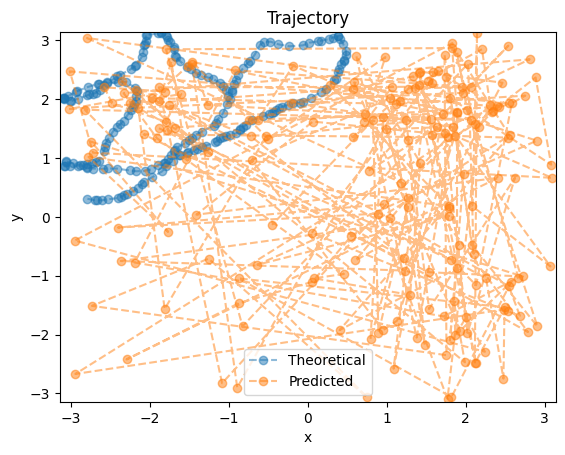

In [12]:
n = 36
plt.plot(labels[n,:,0],labels[n,:,1],"--o", alpha=0.5, label="Theoretical")
plt.plot(out_decoded[n,:,0],out_decoded[n,:,1],"--o", alpha=0.5, label="Predicted")
# plt.plot(out[n,:,0],out[n,:,1],"--o", alpha=0.5, label="Predicted")
# plt.plot(path[n,:,0],path[n,:,1],"--o", alpha=0.5, label="Predicted")
plt.legend()
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi,np.pi)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Trajectory")
plt.show()

Mean error:  0.45613027
Mean end error:  0.57980615


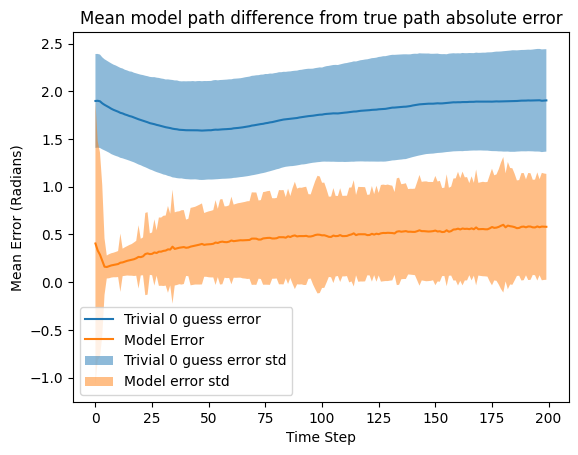

In [37]:
# FOR RANDOMSTART MUST ADD START TO PATH

# Calculate path error
path = out_decoded.numpy()
# path = out
y = labels
path_err = np.sqrt(np.abs(path[:,:,0]-y[:,:,0])**2 + np.abs(path[:,:,0]-y[:,:,0])**2)
path_err_mean = np.mean(path_err,axis=0)
path_err_mean_std = np.std(path_err,axis=0)
t_test = path_err.shape[1]
# Calculate trivial path error
y_mean = np.mean(np.abs(y-0),axis=0)
y_mean_std = np.std(np.abs(y-0),axis=0)
trivial_path_err = np.sqrt(np.abs(path[:,:,0]-y_mean[:,0]) + np.abs(path[:,:,1]-y_mean[:,1]))
trivial_path_err_mean = np.mean(trivial_path_err,axis=0)
trivial_path_err_mean_std = np.std(trivial_path_err,axis=0)
# Print mean error
print("Mean error: ",np.mean(path_err))
print("Mean end error: ",path_err_mean[-1])

# Plot
plt.plot(trivial_path_err_mean,label="Trivial 0 guess error")
plt.plot(path_err_mean,label="Model Error")
plt.fill_between(np.arange(t_test),trivial_path_err_mean-trivial_path_err_mean_std,trivial_path_err_mean+trivial_path_err_mean_std,alpha=0.5, label="Trivial 0 guess error std")
plt.fill_between(np.arange(t_test),path_err_mean-path_err_mean_std,path_err_mean+path_err_mean_std,alpha=0.5, label="Model error std")
plt.legend()
plt.title("Mean model path difference from true path absolute error")
plt.xlabel("Time Step")
plt.ylabel("Mean Error (Radians)")
plt.show()

### Full 2D non-low

In [17]:
n_test = 1000
t_test = 60
data,labels = smooth_wandering_2D_squarefix_randomstart_hdv(n_test,t_test,bound=0.5,v_sigma=0.01,d_sigma=0.1,v_bound_reduction=0.15,stability=0.01)
# data,labels = smooth_wandering_2D_squarefix(n_test,t_test,bound=0.5,v_sigma=0.01,d_sigma=0.08,v_bound_reduction=0.15,stability=0.00)
data,labels_convert = hd_direction_input_convert_partial(data,labels)

# labels = torch.cat((torch.zeros((labels.shape[0],1,labels.shape[2])),labels),dim=1)

# Inference
out = model1(data)
out = out.permute(1,0,2)[:,1:,:]

labels = labels.detach().cpu().numpy()
labels_convert = labels_convert.detach().cpu().numpy()
out = out.detach().cpu().numpy()
data = data.detach().cpu().numpy()


# Shift the predicted values so that the first timestep aligns with theoretical value
# out = out - np.expand_dims((out[:,0,:] - labels[:,0,:]),1)

mse = np.mean((labels_convert-out)**2)
# mse = np.mean((labels-out)**2)
# mse = np.mean((labels-out_shifted)**2)
print(mse)

0.17389421


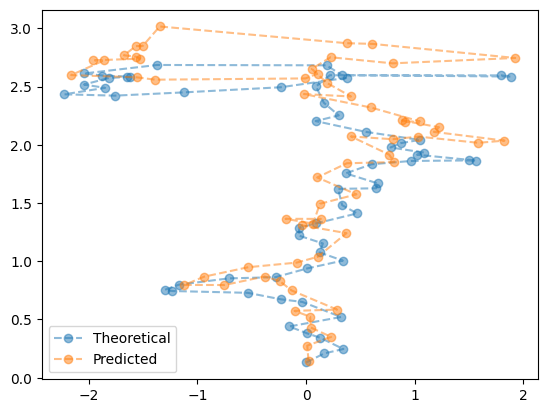

In [18]:
n = 16
plt.plot(labels_convert[n,:,0],labels_convert[n,:,1],"--o", alpha=0.5, label="Theoretical")
plt.plot(out[n,:,0],out[n,:,1],"--o", alpha=0.5, label="Predicted")
# plt.plot(out[n,:,0],out[n,:,1],"--o", alpha=0.5, label="Predicted")
# plt.plot(path[n,:,0],path[n,:,1],"--o", alpha=0.5, label="Predicted")
plt.legend()
# plt.xlim(-np.pi,np.pi)
# plt.ylim(-np.pi,np.pi)
plt.show()

Mean error:  0.11219199
Mean end error:  0.24007508


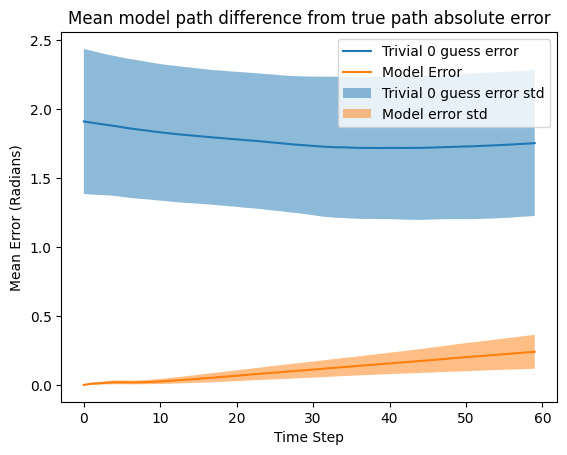

In [38]:
# Calculate path error
path = out
# path = out
y = labels
path_err = np.sqrt(np.abs(path[:,:,0]-y[:,:,0])**2 + np.abs(path[:,:,0]-y[:,:,0])**2)
path_err_mean = np.mean(path_err,axis=0)
path_err_mean_std = np.std(path_err,axis=0)
t_test = path_err.shape[1]
# Calculate trivial path error
y_mean = np.mean(np.abs(y-0),axis=0)
y_mean_std = np.std(np.abs(y-0),axis=0)
trivial_path_err = np.sqrt(np.abs(path[:,:,0]-y_mean[:,0]) + np.abs(path[:,:,1]-y_mean[:,1]))
trivial_path_err_mean = np.mean(trivial_path_err,axis=0)
trivial_path_err_mean_std = np.std(trivial_path_err,axis=0)
# Print mean error
print("Mean error: ",np.mean(path_err))
print("Mean end error: ",path_err_mean[-1])

# Plot
plt.plot(trivial_path_err_mean,label="Trivial 0 guess error")
plt.plot(path_err_mean,label="Model Error")
plt.fill_between(np.arange(t_test),trivial_path_err_mean-trivial_path_err_mean_std,trivial_path_err_mean+trivial_path_err_mean_std,alpha=0.5, label="Trivial 0 guess error std")
plt.fill_between(np.arange(t_test),path_err_mean-path_err_mean_std,path_err_mean+path_err_mean_std,alpha=0.5, label="Model error std")
plt.legend()
plt.title("Mean model path difference from true path absolute error")
plt.xlabel("Time Step")
plt.ylabel("Mean Error (Radians)")
plt.show()